In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# for Amon data
def model_climate_data(model, variable):

    # Extract the part of the catalog that goes with these search terms
    model_var_hist = catalog.search(source_id = model, experiment_id='historical', table_id= 'Amon', variable_id=variable)
    model_var_ssp = catalog.search(source_id = model, experiment_id='ssp370', table_id= 'Amon', variable_id=variable)
    
    # Make a list of the unique ensemble members
    # historical
    mems_hist = model_var_hist.df.member_id.unique()
    # SSP
    mems_ssp = model_var_ssp.df.member_id.unique()

    # Convert these to sets, find the intersection between them, and convert back to a list
    common_mems = list(set(mems_hist) & set(mems_ssp))
    
    # Define an empty list for output data
    model_data = []

    # Retrieve number of members the historical and SSP ensembles have in common
    num = len(common_mems)

    # Loop over all members-in-common
    for mem in range(num):
        # Print statement to keep track of which member we're working on
        print(common_mems[mem])
    
        # Figure out where this member is in the historical ensemble
        # True/False array showing whether or not the member_id matches our member of interest
        hist_mask = model_var_hist.df['member_id'] == common_mems[mem]
        # extract (first) location where the mask is True
        hist_loc = model_var_hist.df['member_id'][hist_mask].index[0]
    
        # Do the same thing for the SSP ensemble
        ssp_mask = model_var_ssp.df['member_id'] == common_mems[mem]
        ssp_loc = model_var_ssp.df['member_id'][ssp_mask].index[0]
    
        # Extract data from each entry as xarray
        data_hist = xr.open_zarr(model_var_hist.df['zstore'][hist_loc], storage_options={'anon': True})
        data_ssp = xr.open_zarr(model_var_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
        data_hist['time'] = data_hist.time.astype('datetime64[ns]')
        data_ssp['time'] = data_ssp.time.astype('datetime64[ns]')
    
        data_hist = data_hist.sel(time = slice('1850-01-01', '2014-12-31'))
        data_ssp = data_ssp.sel(time = slice('2015-01-01', '2100-12-31'))
    
        # Concatenate the historical and SSP data across the time dimension
        data = xr.concat([data_hist, data_ssp], dim="time")
    
        # Add the concatenated data to a list
        model_data.append(data)

    # Concatenate the list into a single xarray object
    model_data = xr.concat(model_data, dim="member")

    # Store the actual member information as values of the new dimension
    model_data = model_data.assign_coords(member=("member", common_mems))
    
    # Get data for an earlier period: 20th century
    data_early = model_data.sel(time=slice("1850-01-01", "1900-12-31"))

    # Get data for a later period: 21st century
    data_late = model_data.sel(time=slice("2050-01-01", "2100-12-31"))
    
    # Take the time average
    data_early_mn = data_early.mean(dim="time")
    data_late_mn = data_late.mean(dim="time")

    # Extract the values into Numpy arrays
    pr_early = data_early_mn[variable].values
    pr_late = data_late_mn[variable].values
    
    # Define empty output arrays
    # T-test
    pr_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
    # Rank-sum test
    pr_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

    # Loop over lat, lon in the Numpy array
    for latidx in range(len(data_early_mn.lat)):
        for lonidx in range(len(data_early_mn.lon)):
            # Run test on each grid point
            # T-test
            ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
            # Rank-sum
            stat_rs, pval_rs = stats.ranksums(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        
            # Save results in the output array
            pr_pvals_rs[latidx, lonidx] = pval_rs
            pr_pvals_t[latidx, lonidx] = ttest.pvalue
            
    # Calculate ensemble-mean epoch difference
    ensmn_prdiff = pr_late.mean(axis=0) - pr_early.mean(axis=0)

    # Define object containing PlateCarree projection
    map = ccrs.PlateCarree()

    # Create figure/axis objects, use the map object to specify associated projection
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
    # Plot temperature data on the axes using the coolwarm colormap
    plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_prdiff, 
                     transform=map, cmap="Reds") #vmin=-6, vmax=6

    # Add colorbar and label it
    cbar = plt.colorbar(plot, ax=ax)
    cbar.set_label(f'{variable} ({model_data[variable].units})', fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    # Add coastline/border lines
    # Set the extent to Indonesia
    ax.set_extent([92, 146, -15, 10], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    # Add grid lines
    gl = ax.gridlines(draw_labels=True, linestyle="--") 
    gl.top_labels = False
    gl.right_labels = False

    # Set font size for x, y-axis labels
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}


    # Statistical significance for historical vs future precip change regressed on gradient change
    latitudes, longitudes = np.where(pr_pvals_rs < 0.05)
    lats = data_early_mn.coords['lat'][latitudes].values
    lons = data_early_mn.coords['lon'][longitudes].values
    ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

    # Add title, show plot
    ax.set_title(f"{model}: {variable} (Late - Early)", fontsize= 20)
    plt.show()

r11i1p1f1
r4i1p1f1
r10i1p1f1


/tmp/ipykernel_4034081/786651328.py:85: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])


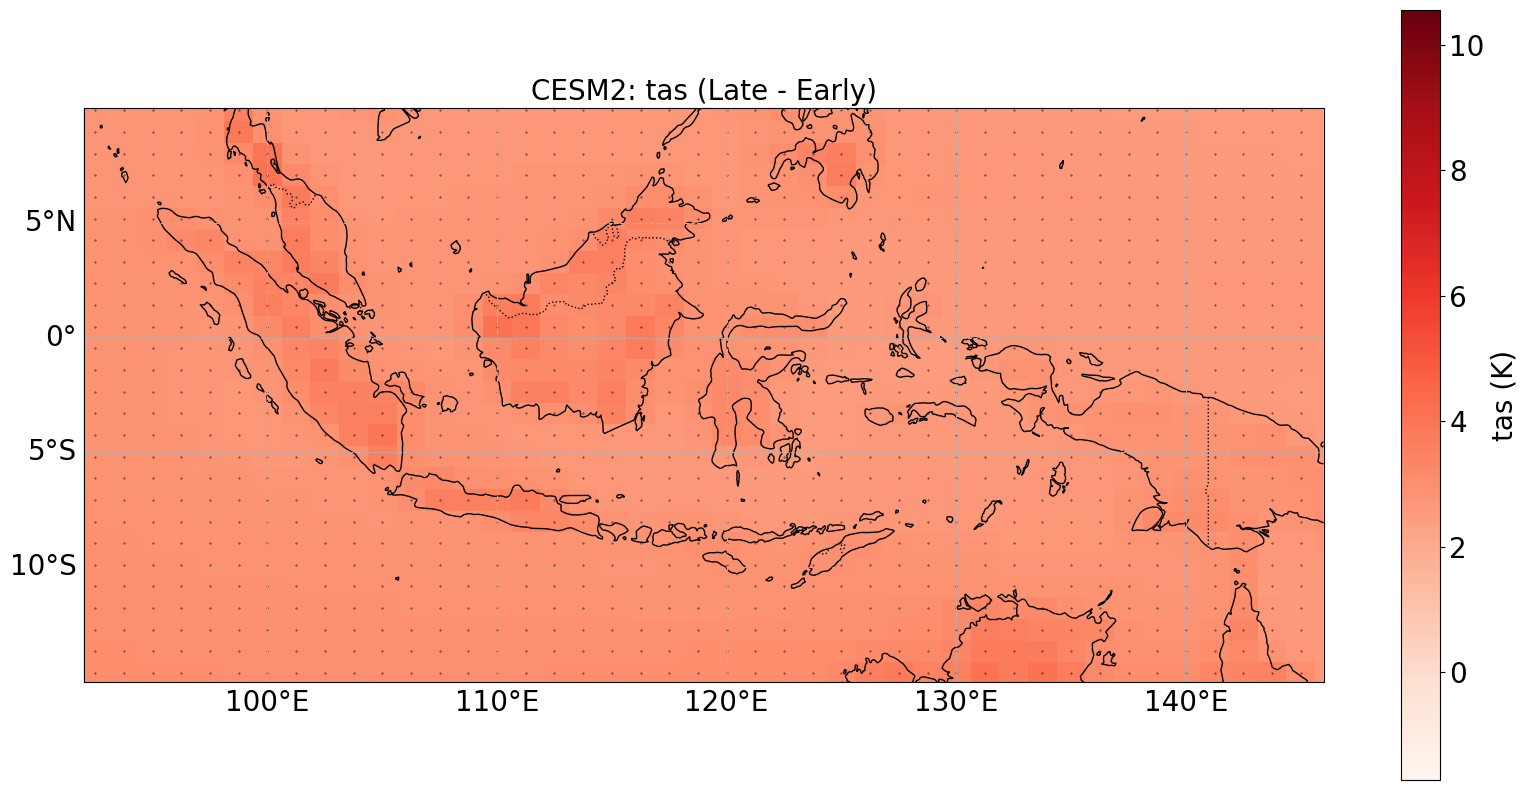

In [4]:
model_climate_data('CESM2', 'tas')

r11i1p1f1
r4i1p1f1
r10i1p1f1


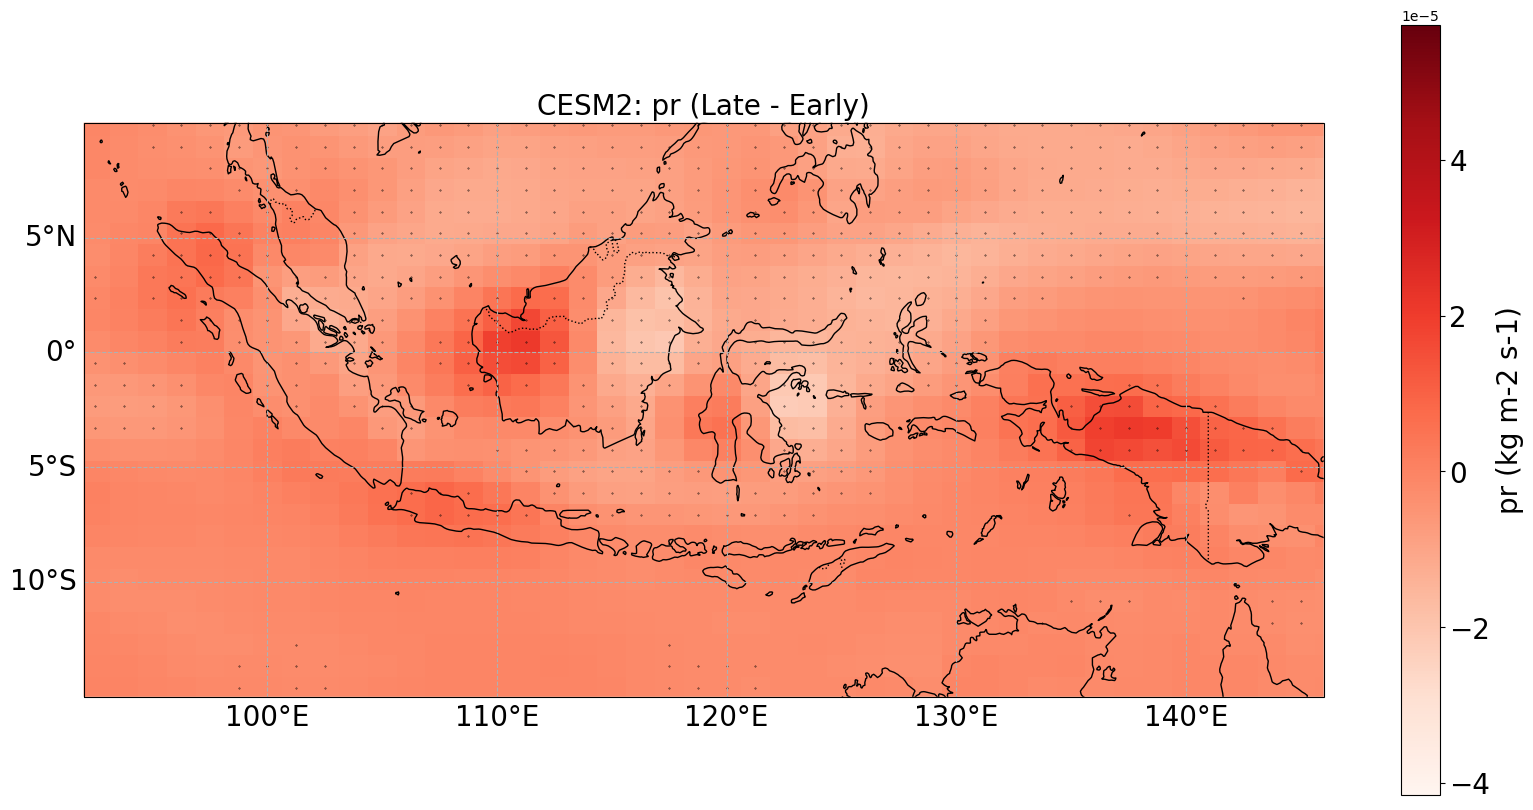

In [5]:
model_climate_data('CESM2', 'pr')

r2i1p1f1
r5i1p1f1
r4i1p1f1
r3i1p1f1
r1i1p1f1


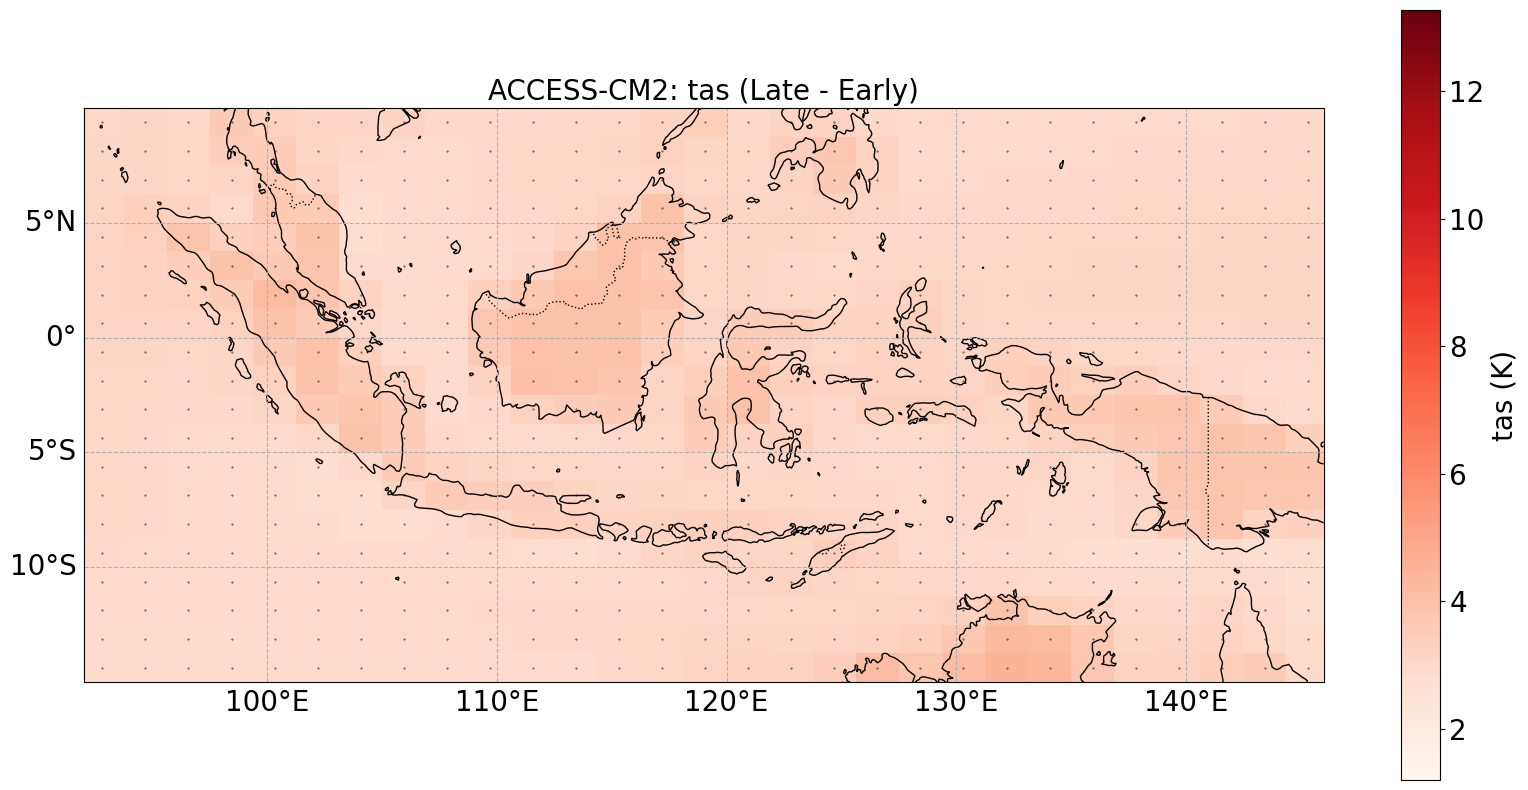

In [6]:
model_climate_data("ACCESS-CM2", 'tas')

r2i1p1f1
r5i1p1f1
r4i1p1f1
r3i1p1f1
r1i1p1f1


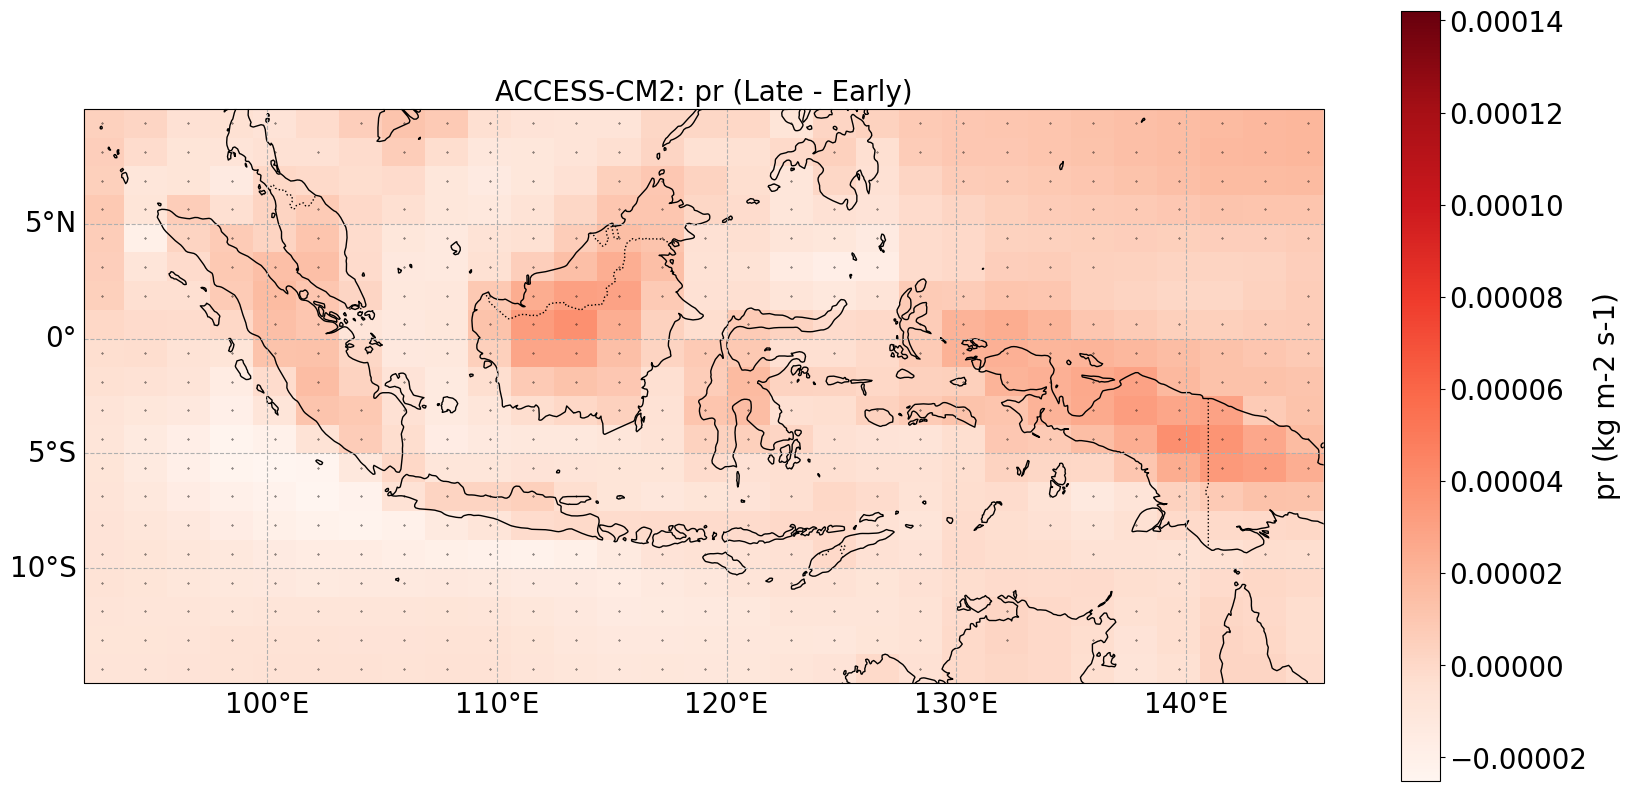

In [7]:
model_climate_data("ACCESS-CM2", 'pr')